# Capstone Project - Datrition 
###### Team:  Omar Alharbi - Mansour Aljuaid  - Sumaiah Alsadhan

# Problem Statement 

---

# Model

## Importing Libraries¶

In [1]:
import cv2
import os
from skimage import color, data, io, measure
from skimage.filters import threshold_otsu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm
import glob
import matplotlib.image as mpimg
%matplotlib inline
mpl.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi']= 330 #UPDATED
plt.rc("savefig", dpi=330) #UPDATED

In [2]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = False

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "right-to-left":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [27]:
def f(y):
    # Defining a kernel length
    global horizontal_lines_img, verticle_lines_img, kernel
    kernel_length = np.array(img).shape[1]//y

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    ###kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=1)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=1)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=1)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=1)
    ###plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
    ###plt.imshow(verticle_lines_img);
    ###plt.axis('off')

    ###plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
    plt.imshow(horizontal_lines_img);
    plt.axis('off')

In [28]:
#  images.append(mpimg.imread(img_path))
#     print("Processing Image", len(images))

---

## Images Pre-Processing 
### Processing from img Folder, then saving them in another folder named : 'img_result'

100%|██████████| 24/24 [12:25<00:00, 47.95s/it]


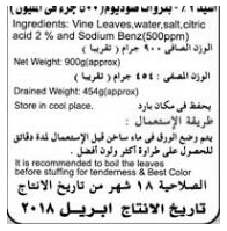

In [29]:
images = []
counter = 1
for img_path in tqdm(glob.glob('img/*.jpg')):
    
    img = cv2.imread(img_path,0)
    (thresh, img_bin) = cv2.threshold(img, 240, 255,cv2.THRESH_OTSU| cv2.ADAPTIVE_THRESH_GAUSSIAN_C) # UPDATE
    img_bin = 255-img_bin
    f(255)
    alpha = 0.1
    beta = 1.5 - alpha #UPDATE
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.5)
    #img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 230,255, cv2.THRESH_OTSU| cv2.ADAPTIVE_THRESH_GAUSSIAN_C) # UPDATE
    plt.axis('off')
    plt.imshow(img_final_bin)
#     images.append(mpimg.imread(img_path))
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #UPDATE

    # Sort all the contours by top to bottom.
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    idx = 1
    
    for c in (contours):
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
        
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
        if (w > 160 and h > 80) and w < 2.5 *h:
            idx += 3
            new_img = img[y:y+h, x:x+w]
            #plt.subplot(2,3, idx)
            plt.imshow(new_img)
            plt.axis('off')
            #cv2.imwrite('./th/')
            #path = './th/'
            #plt.savefig(f'./img_result/label{counter}.jpg',dpi=300)
            #cv2.imwrite(os.path.join(path , 'label'+str(num)+'.jpg'), new_img)
            #cv2.imwrite(os.path.join(path , 'f', new_img))
            file_n = img_path.split('_')[-1].split('.')[0]
            plt.savefig(f'./img_result/{file_n}_Nutritions_{counter}.jpg',dpi=330) #UPDATED
            counter+=1
            #cv2.waitKey(0)
    #break

In [31]:
new_img

array([[152, 244, 188, ..., 238, 192,  67],
       [139, 251, 177, ..., 242, 186,  67],
       [142, 255, 177, ..., 233, 197,  66],
       ...,
       [202, 194, 189, ..., 199, 198, 196],
       [199, 199, 197, ..., 194, 207, 196],
       [192, 201, 201, ..., 205, 205, 197]], dtype=uint8)

---

## Extracting text from Nutrition lables
    OCR (pytesseract) and Open CV

### Importing Packages & Libraries:

In [32]:
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter
import os
import glob
import re
import sys
import cv2
import post_process

### Applicatopn of OCR on images saved at 'img_result'

In [36]:
def label_Recognizer(path):
    import re
    import os
    from matplotlib import pyplot 
    files = []
    for  r,d, f in os.walk(path):
        print(f)
        print(d)
        print(r)
        for file in f:
            files.append(os.path.join(file))
    p = re.compile('[0-9]+.jpg')
    all_result = []
    for f in files:
        #print(f)
     #   out_dict = end_to_end.end_to_end(f'{path}\{f}')
        #-----------------

        for file in glob.glob('img_result/*.jpg'):
            bw = cv2.imread(file, 0)

        # Apply adaptive thresholding to images | @Suma Not Required already applied in image processing.
#             thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                 cv2.THRESH_BINARY, 11, 2)

        # Get text recognition from thresholded images
            output = pytesseract.image_to_string(Image.fromarray(bw))

            fileName = p.findall(file)[0]
            print ("Proccessing " + fileName)
            #outFileName = fileName[0:len(fileName)-4]
            # Get default text recognition 
            #output = pytesseract.image_to_string(Image.open(file))
            x = post_process.post_process(output)
            print("\n Completed Labels for:", '\n', fileName, '\n', output)
            all_result.append(x)
            x['product_id']=file
        result = []
        for i in all_result:
            if len(i) == 0:
                pass
            else:
                result.append(i)
        return result

In [34]:
n = label_Recognizer('img_result/')

['1_Nutritions_29.jpg', '9_Nutritions_127.jpg', '73_Nutritions_21.jpg', '6_Nutritions_75.jpg', '5_Nutritions_101.jpg', '8_Nutritions_115.jpg', '81_Nutritions_135.jpg', '12_Nutritions_69.jpg', '12_Nutritions_68.jpg', '81_Nutritions_134.jpg', '8_Nutritions_114.jpg', '5_Nutritions_100.jpg', '6_Nutritions_74.jpg', '73_Nutritions_20.jpg', '9_Nutritions_126.jpg', '1_Nutritions_28.jpg', '9_Nutritions_124.jpg', '73_Nutritions_22.jpg', '6_Nutritions_76.jpg', '5_Nutritions_102.jpg', '8_Nutritions_116.jpg', '81_Nutritions_136.jpg', '8_Nutritions_117.jpg', '5_Nutritions_103.jpg', '6_Nutritions_77.jpg', '73_Nutritions_23.jpg', '3_Nutritions_48.jpg', '9_Nutritions_125.jpg', '9_Nutritions_121.jpg', '80_Nutritions_129.jpg', '73_Nutritions_27.jpg', '6_Nutritions_73.jpg', '7_Nutritions_49.jpg', '5_Nutritions_107.jpg', '.DS_Store', '8_Nutritions_113.jpg', '81_Nutritions_133.jpg', '81_Nutritions_132.jpg', '5_Nutritions_112.jpg', '5_Nutritions_106.jpg', '6_Nutritions_72.jpg', '73_Nutritions_26.jpg', '80_Nu

Proccessing 69.jpg
[('Serving Size', '15', 0), ('Serving Per Container', '4', 1), ('Omg(0%DV)', '', 2), ('Daily Values(DV) are based on a', '2,000 calorie die', 3)]



[('Serving Size', '15', 0), ('Serving Per Container', '4', 1)]



[('Serving Size', '15', 0), ('Serving Per Container', '4', 1)]



[('Serving Size', '15', 1)]



[('Serving Size', '15', 1)]




 Completed Labels 
 69.jpg 
 NUTRITION FACTS
Serving Size:15g
Serving Per Container:48

Amount Per Serving

Omg(0%DV)

Not a significant source of calories from
fat,saturated fat,trans fat,cholesterol,dietary
fiber,vitamin A vitamin C calcium and iron.Percent
Daily Values(DV) are based on a 2,000 calorie diet
Proccessing 68.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 68.jpg 
 
Proccessing 134.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 134.jpg 
 
Proccessing 114.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 114.jpg 
 
Proccessing 100.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 100.jpg 
 


Proccessing 112.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 112.jpg 
 
Proccessing 106.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 106.jpg 
 
Proccessing 72.jpg
[('Sie', '305 E', 0), ('6°253501°304', '168) ; seni', 1)]



[]



[]



[]



[]




 Completed Labels 
 72.jpg 
 4h

| | y Uiitneo ee Col
Sie 305 E

6°253501°304 168) ; seni
Proccessing 26.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 26.jpg 
 
Proccessing 128.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 128.jpg 
 o ll iM
Proccessing 122.jpg
[('12 cm x', '12 cm', 0)]



[]



[]



[]



[]




 Completed Labels 
 122.jpg 
 12 cm x 12 cm
Proccessing 24.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 24.jpg 
 
Proccessing 110.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 110.jpg 
 
Proccessing 104.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 104.jpg 
 8 850227 | 022406 |
Proccessing 57.jpg
[('ko pert - ECD one OF', '1', 0), ('FH? oO IIS SED Corre oe (THe (FP Ho

Proccessing 146.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 146.jpg 
 
Proccessing 39.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 39.jpg 
 
Proccessing 18.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 18.jpg 
 CAKERS
Proccessing 142.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 142.jpg 
 
Proccessing 4.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 4.jpg 
 
Proccessing 140.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 140.jpg 
 
Proccessing 158.jpg
[('i“', '7 “7 mic 4', 0)]



[]



[]



[]



[]




 Completed Labels 
 158.jpg 
 i“ 7 “7 mic 4a
Proccessing 90.jpg
[('Serv. Size', '1/4 Cup (30g', 0), ('Chalories', '', 1), ('Total Fat', '0g t', 2), ('Total Carb.', '0', 3), ('|', '772504 ill lI', 4), ('Pee', '12: aball moet', 5), ('Gross Wt :', '14 K', 6), ('Netwt ', '12K', 7), ('Liquid Wt :', '8 K', 8)]



[('Serv. Size', '1/4 Cup (30g', 0), ('Chalories', '', 1), ('Total Fat', '0g t', 2), ('Total Carb.', '0', 3)]



[('Serv. Size',

Proccessing 11.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 11.jpg 
 Did you know Delamere milk has
a brilliant flavour and it’s fat
free! It's ideal for cooking and

baking. Plus it’s also great in your
tea or coffee. Visit our website
. for delicious recipe ideas.
Proccessing 83.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 83.jpg 
 
Proccessing 157.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 157.jpg 
 
Proccessing 98.jpg
[('7 Slices Per Pack', 'Slices Per Pack', 0)]



[]



[]



[]



[]




 Completed Labels 
 98.jpg 
 enn Th Sis cel

 

are ee rigs
meal!
7 Slices Per Pack
Proccessing 156.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 156.jpg 
 
Proccessing 82.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 82.jpg 
 
Proccessing 16.jpg
[('ec ee:', '3', 0), ('i iba ed fm', '1 ae ip pan a vn mie ra', 1), ("Woo'sdoossuaNVD suIWOLSND SLI ", '1 sIONGOW ALIN ALTHO', 2), ('WILONDIVE IV ', '07 LM aN DRICACH CLOALUWOD SISWEN', 3), ('MCN].', '8 

Proccessing 149.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 149.jpg 
 
Proccessing 15.jpg
[('Milk', '1I', 0), ('essa €', '5 je plme sy Gula 12 gSal', 1)]



[]



[]



[]



[]




 Completed Labels 
 15.jpg 
 Delamere Dairy Sterilized Skimmed Cow's
Milk 1It

SA (peed coll) aauall & gba Shy couple os jad Spel

essa €.5 je plme sy Gula 12 gSall

 

Issa eli)

KM /
Proccessing 5.jpg
[('ea ek mit -t', '1e L', 0), ('and use within', '3 days', 1), ('XS rte Mieco Ca ColeL', '1', 2), ('8400kJ/2000kcal =', '70g', 3), ('20g, be', '6g', 4), ('120mg', '(15%) per 100mI/300mg pe', 5), ('portion ', '250ml). 300mg is 37.5% of an adult', 6)]



[]



[]



[]



[]




 Completed Labels 
 5.jpg 
 Delamere Dairy

skimmed, sterilised, homogenised milk

Our milk is carefully heat
treated to give you a long-life
cows’ milk that’s extra delicious.

MoM ole MorM ictal
and keeps in the cupboard
ea ek mit -t-1e LB

Did you know Delamere milk has
Q brilliant flavour and Tt’s fat
free! It's ideal fo

Proccessing 50.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 50.jpg 
 
Proccessing 130.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 130.jpg 
 
Proccessing 36.jpg
[]



[]



[]



[]



[]




 Completed Labels 
 36.jpg 
 
Proccessing 32.jpg
[('bSigesl Mild ey geS Sam', '7 4Li pal', 0), ('<opbeall jem Boe ‘cha', '44', 1), ('bl bjem', '5 all 4B 5 « Ji', 2), ('AbD iy oo Gast og Galt', '4 Saal i', 3)]



[('bSigesl Mild ey geS Sam', '7 4Li pal', 0)]



[('bSigesl Mild ey geS Sam', '7 4Li pal', 0)]



[]



[]




 Completed Labels 
 32.jpg 
 | Allergen Warming: May Contain Tree |
Nuts, Wheat Gluten and Mustard

Ingredients: Cumin Seed, Black
Pepper, Cinnamon, Cardamom,
Mace, Cloves, Bay Leaves &
Nutmeg

Ingrédients: graines de cumin,
poivre noir, cannelle, cardamome,
mace, clous de girofle, feuilles de
laurier et noix de muscade

bSigesl Mild ey geS Sam 7 4Li pall
<opbeall jem Boe ‘cha 448
bl bjem 5 all 4B 5 « Ji 8

       
   
   
      
   
   
      
     

  

  

N

In [37]:
len(n)

162

### DataFrame Creation from Raw Text

In [38]:
dx = pd.DataFrame(n)

In [39]:
dx.product_id.unique()

array(['img_result/1_Nutritions_29.jpg',
       'img_result/9_Nutritions_127.jpg',
       'img_result/73_Nutritions_21.jpg',
       'img_result/6_Nutritions_75.jpg',
       'img_result/5_Nutritions_101.jpg',
       'img_result/8_Nutritions_115.jpg',
       'img_result/81_Nutritions_135.jpg',
       'img_result/12_Nutritions_69.jpg',
       'img_result/12_Nutritions_68.jpg',
       'img_result/81_Nutritions_134.jpg',
       'img_result/8_Nutritions_114.jpg',
       'img_result/5_Nutritions_100.jpg',
       'img_result/6_Nutritions_74.jpg',
       'img_result/73_Nutritions_20.jpg',
       'img_result/9_Nutritions_126.jpg',
       'img_result/1_Nutritions_28.jpg',
       'img_result/9_Nutritions_124.jpg',
       'img_result/73_Nutritions_22.jpg',
       'img_result/6_Nutritions_76.jpg',
       'img_result/5_Nutritions_102.jpg',
       'img_result/8_Nutritions_116.jpg',
       'img_result/81_Nutritions_136.jpg',
       'img_result/8_Nutritions_117.jpg',
       'img_result/5_Nutritions_103.

In [40]:
dx.product_id = dx.product_id.apply(lambda x:x.replace('img_result/',''))

In [41]:
dx.head()

,Calories,Cholesterol,Dietary Fiber,Energy,Potassium,Protein,Saturated Fat,Serving Size,Sodium,Sugars,Total Carbohydrate,Total Fat,Trans Fat,product_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1_Nutritions_29.jpg
1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,9_Nutritions_127.jpg
2,100,2,NaN,NaN,NaN,NaN,,22,NaN,NaN,NaN,,,73_Nutritions_21.jpg
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6_Nutritions_75.jpg
4,NaN,NaN,NaN,71,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_Nutritions_101.jpg


In [42]:
dx.set_index(keys='product_id').dropna(how='all')

,Calories,Cholesterol,Dietary Fiber,Energy,Potassium,Protein,Saturated Fat,Serving Size,Sodium,Sugars,Total Carbohydrate,Total Fat,Trans Fat
product_id,,,,,,,,,,,,,
9_Nutritions_127.jpg,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN
73_Nutritions_21.jpg,100,2,NaN,NaN,NaN,NaN,,22,NaN,NaN,NaN,,
5_Nutritions_101.jpg,NaN,NaN,NaN,71,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12_Nutritions_69.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN
1_Nutritions_28.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN
6_Nutritions_76.jpg,NaN,NaN,NaN,13.2,NaN,3,NaN,NaN,270,30,21,NaN,NaN
8_Nutritions_117.jpg,15,NaN,NaN,NaN,NaN,NaN,1,28,210,NaN,NaN,NaN,NaN
5_Nutritions_99.jpg,NaN,NaN,NaN,NaN,251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76_Nutritions_3.jpg,67,NaN,NaN,NaN,NaN,NaN,NaN,5,48,NaN,11,NaN,NaN


In [43]:
dx.product_id.unique()

array(['1_Nutritions_29.jpg', '9_Nutritions_127.jpg',
       '73_Nutritions_21.jpg', '6_Nutritions_75.jpg',
       '5_Nutritions_101.jpg', '8_Nutritions_115.jpg',
       '81_Nutritions_135.jpg', '12_Nutritions_69.jpg',
       '12_Nutritions_68.jpg', '81_Nutritions_134.jpg',
       '8_Nutritions_114.jpg', '5_Nutritions_100.jpg',
       '6_Nutritions_74.jpg', '73_Nutritions_20.jpg',
       '9_Nutritions_126.jpg', '1_Nutritions_28.jpg',
       '9_Nutritions_124.jpg', '73_Nutritions_22.jpg',
       '6_Nutritions_76.jpg', '5_Nutritions_102.jpg',
       '8_Nutritions_116.jpg', '81_Nutritions_136.jpg',
       '8_Nutritions_117.jpg', '5_Nutritions_103.jpg',
       '6_Nutritions_77.jpg', '73_Nutritions_23.jpg',
       '3_Nutritions_48.jpg', '9_Nutritions_125.jpg',
       '9_Nutritions_121.jpg', '80_Nutritions_129.jpg',
       '73_Nutritions_27.jpg', '6_Nutritions_73.jpg',
       '7_Nutritions_49.jpg', '5_Nutritions_107.jpg',
       '8_Nutritions_113.jpg', '81_Nutritions_133.jpg',
       '81_Nut

In [44]:
dx.shape

(162, 14)

#### Creating A Dataframe from Raw Text (Try 1)

In [ ]:
test = n[0].split('\n')

In [ ]:
#df_test = pd.DataFrame(test)

In [ ]:
#df_test[0][19]

In [ ]:
df_test

In [ ]:
df_test = df_test.rename(columns={0:'data'})

In [ ]:
df_test[df_test['data'].str.contains('Serving')]

In [ ]:
df_test['data'].str.extract('(\d+?[Aa-zZ]+)')

## Reference_codes

### All_Labels:

In [ ]:

#sys.path.append('/usr/local/lib/python2.7/site-packages')


def writeFile(directory, fileName, content):
    outFile = open('outputs/' + directory + '/' + fileName + '.txt', 'w')
    outFile.write(content)
    outFile.close()

# Setup regex for stripping file names
p = re.compile('[0-9]+.jpg')
    
# Use images in the labels directory
for file in glob.glob('../labels/*.jpg'):
    fileName = p.findall(file)[0]
    print ("Proccessing " + fileName)
    outFileName = fileName[0:len(fileName)-4]
    # Get default text recognition 
    output = pytesseract.image_to_string(Image.open(file))
    #print(output)

    # Write default text output to 'outputs/default' directory
    writeFile('default', outFileName, output)

    # Open image as black and white
    bw = cv2.imread(file, 0)

    # Apply adaptive thresholding to images
    thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, 11, 2)

    # Get text recognition from thresholded images
    output = pytesseract.image_to_string(Image.fromarray(bw))
    writeFile('bw', outFileName, output)

    break

In [ ]:
def label_Recognizer(path):
    import re
#    import end_to_end
    import os
    from matplotlib import pyplot 
    files = []
    # r=root, d=directories, f = files
    for  r,d, f in os.walk(path):
        for file in f:
            files.append(os.path.join(file))
    p = re.compile('[0-9]+.jpg')
    all_result = []
    for f in files:
        print(f)
     #   out_dict = end_to_end.end_to_end(f'{path}\{f}')
        #-----------------
        for file in glob.glob('./img_result/*.jpg'):
            fileName = p.findall(file)[0]
            print ("Proccessing " + fileName)
            outFileName = fileName[0:len(fileName)-4]
            # Get default text recognition 
            output = pytesseract.image_to_string(Image.open(file))
            print("/n", output)
            all_result.append(output)

            # Write default text output to 'outputs/default' directory
#             writeFile('default', outFileName, output)

#             # Open image as black and white
#             bw = cv2.imread(file, 0)

#             # Apply adaptive thresholding to images
#             thresh = cv2.adaptiveThreshold(bw, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                     cv2.THRESH_BINARY, 11, 2)

#             # Get text recognition from thresholded images
#             output = pytesseract.image_to_string(Image.fromarray(bw))
                

#         #-----------------
# #         print('This is out_dict type', type(out_dict))
# #         print(f.replace(r'.jpg',''))
# #         out_dict['Image_id']=f.replace(r'.jpg','')
#             all_result.append(output)
            
#         break

    df = pd.DataFrame(all_result)
    df = pd.DataFrame(columns=['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language'])
    df_long = df.melt(id_vars=['Serving Size','Image_id'])
    Units = {'Calories': 'Kcal',
        'Energy': 'kJ',
        'Total Fat': 'g',
        'Saturated Fat': 'g',
        'Trans Fat': 'g',
        'Poly Fat': 'g',
        'Mono Fat': 'g',
        'Cholesterol': 'mg',
        'Sodium': 'mg',
        'Potassium': 'g',
        'Total Carbohydrate': 'g',
        'Dietary Fiber': 'g',
        'Sugars': 'g',
        'Protein': 'g'}
    df_long['Serving Size Unit']= 'g'
    df_long.columns = ['Serving Size','Image_id','Nutrient','Amount','Serving Size Unit']
    df_long['Unit'] = [Units [x] for x in df_long['Nutrient']]
    df_long['Language'] = 'English'
    Final_Outcome = df_long[['Image_id','Nutrient', 'Amount', 'Unit', 'Serving Size','Serving Size Unit','Language']]
    Final_Outcome.to_excel('DSI-V-Abdulrahman.xlsx', index=False)
    return Final_Outcome

In [ ]:
basename = os.path.basename("./img_result")
label_impath = impath.replace(basename, 'tmp_' + basename)
# label_impath = impath.lower().replace('.jpg', 'label_tmp.jpg')
cv2.imwrite(label_impath, label_im)

start = timer()
# Apply Tesseract to image
output = apply_tesseract(label_impath, demo=demo)
#        print ("\n")
output = pytesseract.image_to_string(label_impath,lang='eng')
#     print(arabic)

end = timer()
print('OCR time: %2f' % (end-start))
os.remove(label_impath)

start = timer()
ocr_label = post_process(output, demo=demo)
print(ocr_label)

end = timer()
print('Post process time: %2f' % (end-start))

if show:
    draw_image(label_im, 'Transformed label: %s' % impath)

return ocr_label

### image view

In [ ]:
io.imshow('./test_result.png')

### Text with Tesseract - codes:

In [ ]:

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter

im = Image.open("test_result.png") # the second one 
im = im.filter(ImageFilter.MedianFilter())
enhancer = ImageEnhance.Contrast(im)
im = enhancer.enhance(22)
im = im.convert('1')
im.save('test2.jpg')

text = pytesseract.image_to_string(Image.open('test2.jpg'))
print(text)

#### Method 2

In [ ]:
# A seconde way to extract text - OCR 
import os
import tempfile
import subprocess

def ocr(path):
    temp = tempfile.NamedTemporaryFile(delete=False)

    process = subprocess.Popen(['tesseract', path, temp.name], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    process.communicate()

    with open(temp.name + '.txt', 'r') as handle:
        contents = handle.read()

    os.remove(temp.name + '.txt')
    os.remove(temp.name)

    return contents

str = ocr('test_result.png')
print(str)

In [ ]:
img = cv2.imread('img/product_5.jpg',0)

In [ ]:
idx = 0
boxes = []
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])
        idx = 0
boxes = []
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        boxes.append(img[y:y+h, x:x+w])

In [ ]:
boxes